In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from skimage.feature import hog
import skimage
from skimage.io import imread, imshow
from skimage.filters import prewitt_h,prewitt_v

In [2]:
# HELPER CLASS TO HANDLE DATA SET AND TRAIN, TEST IMGAGES

class data_handle():
    
    # INITIALIZE DATA SET, CLASS AND LABELS
    def __init__(self, path = "../"):
        np.random.seed()
        # DATA
        self.data = pd.read_csv(path + "Data_Entry_2017.csv").values
        
        # CLASS COUNT & LABELS
        self.classes = dict()
        self.labels = dict()
        
        for i in range(self.data.shape[0]):
            items = self.data[i, 1].split('|')
            for j in items:
                self.classes[j] = self.classes.get(j, 0) + 1
                if j not in self.labels:
                    self.labels[j] = len(self.labels)
        
        # TRAIN LIST
        self.train_file = open(path+"train_val_list.txt", "r")
        self.train = list()
        for x in self.train_file:
            y = x.rstrip("\n")
            self.train.append(y)
        
        # TEST LIST
        self.test_file = open(path+"test_list.txt", "r")
        self.test = list()
        for x in self.test_file:
            y = x.rstrip("\n")
            self.test.append(y)
        
    # EXTRACT N RANDOM NUMBER OF CLASSES
    def extract_random_train_samples(self, n = 100, include = np.arange(0,15)):
        np.random.seed()
        train = np.empty((1,2))
        for x, y in self.labels.items():
            if(y not in include):
                continue
            # FIND CLASS FROM DATA_LIST
            idx = np.where(np.char.find(list(self.data[:, 1]), str(x)) >=0)
            data_sub = self.data[idx, 0]
            data_sub = data_sub[0]
            # RANDOM N SAMPLES
            if(self.classes[x] > n):
                data_sub = np.random.choice(data_sub, n)
            data_sub = data_sub.reshape((data_sub.shape[0], 1))
            lab = int(y)*np.ones((data_sub.shape[0], 1), dtype=np.int8)
            data_sub = np.hstack((data_sub, lab))
            train = np.vstack((train, data_sub))

        return train[1:, :]
    
    # OUTPUTS IMAGE PIXELS
    def find_img(self, img, path="../images/"):
        return plt.imread(path+img)
        
    # CROP X AND Y PIXELS FROM CENTER 
    def center_crop(self, img, x = 800, y = 800):
        xx = img.shape[1]
        yy = img.shape[0]
        img_out = img[int(yy/2-y/2):int(yy/2+y/2), int(xx/2-x/2):int(xx/2+x/2)]
        return img_out
    
    # SCALE IMAGE
    def resize(self, img, val=1024):
        return cv2.resize(img, (val, val), interpolation=cv2.INTER_LINEAR)
    
    # -------------------------------------------- Features ------------------------------------------------
    # HOG feature
    def hog_img(self, img, cell_size = (8,8), o = 9):
        return hog(img, orientations=o, pixels_per_cell=cell_size, cells_per_block=(2, 2), feature_vector=True)
    
    # Edge extraction feature
    def edge_extract(self,img):
        #calculating horizontal edges using prewitt kernel
        edges_prewitt_horizontal = prewitt_h(img)
        #calculating vertical edges using prewitt kernel
        edges_prewitt_vertical = prewitt_v(img,cmap='gray')
        return (edges_prewitt_vertical)
    
    def blobitup(self,img):
        return (skimage.feature.blob_log(img, min_sigma=1, max_sigma=50, num_sigma=10, threshold=0.2, overlap=0.5))
        
        
    # GENERATE N NUMBER SAMPLES PER CLASS, PREPROCESS AND OUTPUT LEARNING MATRICES 
    # TODO: ADD FEATURE EXTRACTION AND MAYBE PCA??
    def featurize(self, crop=800, resize=256, n=100, h = False, e = False, blob = False, tryitall = False, include = np.arange(0,15), all_data = False):
        train_list = self.extract_random_train_samples(n, include)
        # X is the feature vector
        X = 0
        del_list = list()
        for x in range(train_list.shape[0]):
            file_name = train_list[x, 0]
            img = self.find_img(file_name, "../images/")
            # CROP, RESIZE AND FLATTEN IMG
            img = self.center_crop(img, crop, crop)
            img_scaled = self.resize(img, resize)

            if not h:
                img = img_scaled.flatten()
                # WEIRD ERROR HERE WHERE IMG NOT SCALING ON CERTAIN IMAGES SO HARD DELETE
                if(img.shape[0] == 512*512):
                    del_list.append(x)
                    continue
                img = img.reshape((1, img.shape[0]))
            
            elif tryitall == True:
                img1 = self.hog_img(img_scaled)
                img1 = img1.flatten()
                
                img2 = self.blobitup(img_scaled)
                img2 = img2.flatten()
                
                img = np.hstack((img1,img2))
                
                
                
            elif e == True:
                img = self.edge_extract(img_scaled)
                img = img.reshape((1,img.shape[0]))
                
            # HOG img
            elif h== True:
                img = self.hog_img(img_scaled)
                img = img.reshape((1, img.shape[0]))
            
            elif blob == True:
                img = self.blobitup(img_scaled)
                img = img.reshape((1, img.shape[0]))
                
            if(x == 0):
                X = img
            else:         
                X = np.vstack((X, img))
        y = train_list[:, 1]   
        y = np.delete(y, del_list, 0)
        
        return X, y.astype('int')
            
    
    ####### VISUALIZATIONS #######
    
    def plot_bar(self, stuff):
        lists = sorted(stuff.items())
        x, y = zip(*lists)
        fig, ax = plt.subplots()
        ax.bar(x, y)
        fig.autofmt_xdate()
        plt.show()
        
    # CROPPED AND RESIZED TO 750X750 AND TO 256X256 RESPECTIVELY
    def view_class_examples(self, path="../images/", crop=800, res=256):
        
        for x in self.classes:
            idx = np.where(np.char.find(list(self.data[:, 1]), str(x)) >=0)
            data_sub = self.data[idx, 0]
            img_s = np.random.choice(data_sub[0], 1)
            print("Class: {}".format(x))
            
            plt.figure()
            img = plt.imread(path+img_s[0])
            img = self.center_crop(img, crop, crop)
            img = self.resize(img, res)
            plt.imshow(img, cmap="gray")
            plt.show()
            print("\n")

In [3]:
d = data_handle()
labels = d.labels
classes = d.classes

print("Labels: {}\n".format(labels))
print("Classes: {}\n".format(classes))

Labels: {'Cardiomegaly': 0, 'Emphysema': 1, 'Effusion': 2, 'No Finding': 3, 'Hernia': 4, 'Infiltration': 5, 'Mass': 6, 'Nodule': 7, 'Atelectasis': 8, 'Pneumothorax': 9, 'Pleural_Thickening': 10, 'Pneumonia': 11, 'Fibrosis': 12, 'Edema': 13, 'Consolidation': 14}

Classes: {'Cardiomegaly': 2776, 'Emphysema': 2516, 'Effusion': 13317, 'No Finding': 60361, 'Hernia': 227, 'Infiltration': 19894, 'Mass': 5782, 'Nodule': 6331, 'Atelectasis': 11559, 'Pneumothorax': 5302, 'Pleural_Thickening': 3385, 'Pneumonia': 1431, 'Fibrosis': 1686, 'Edema': 2303, 'Consolidation': 4667}



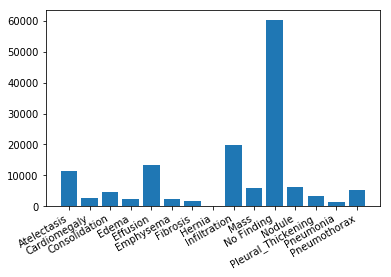

In [4]:
d.plot_bar(classes)

In [5]:
path = "../images/"
image = imread(path+'00000001_000.png', as_gray=True)
from skimage import data, exposure
# imshow(image)
val = 256
img_scaled = cv2.resize(image, (val, val), interpolation=cv2.INTER_LINEAR)
hog_image,p = hog(img_scaled, orientations=9, pixels_per_cell=(8,8), cells_per_block=(2, 2), feature_vector=False,visualize=True,multichannel=False)
# imshow(hog_image)
imshow(p, cmap='gray')

hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))
imshow(hog_image_rescaled)

In [6]:
# edges_prewitt_horizontal = prewitt_h(image)
# # calculating vertical edges using prewitt kernel
# edges_prewitt_vertical = prewitt_v(image)
# imshow(edges_prewitt_vertical, cmap='gray')

In [7]:
# blobs = skimage.feature.blob_log(img_scaled, min_sigma=1, max_sigma=50, num_sigma=100, threshold=0.2, overlap=0.5)
# print(blobs.shape)
# imshow(blobs,cmap='gray' )


# # Compute radii in the 3rd column.
# blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)

# blobs_dog = blob_dog(image_gray, max_sigma=30, threshold=.1)
# blobs_dog[:, 2] = blobs_dog[:, 2] * sqrt(2)

# blobs_doh = blob_doh(image_gray, max_sigma=30, threshold=.01)

# blobs_list = [blobs_log, blobs_dog, blobs_doh]
# colors = ['yellow', 'lime', 'red']
# titles = ['Laplacian of Gaussian', 'Difference of Gaussian',
#           'Determinant of Hessian']
# sequence = zip(blobs_list, colors, titles)

# fig, axes = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)
# ax = axes.ravel()

# for idx, (blobs, color, title) in enumerate(sequence):
#     ax[idx].set_title(title)
#     ax[idx].imshow(image)
#     for blob in blobs:
#         y, x, r = blob
#         c = plt.Circle((x, y), r, color=color, linewidth=2, fill=False)
#         ax[idx].add_patch(c)
#     ax[idx].set_axis_off()

# plt.tight_layout()
# plt.show()

In [8]:
# d.view_class_examples()

In [9]:
# data_sub = d.extract_random_train_samples(50)
# print(data_sub)

In [10]:
# X, y = d.featurize(n=2, h=True, include=(2,5,6,7,8,9))
# print(X)
# print(y)

In [25]:
!jupyter nbconvert --to script helper_VybhavM.ipynb
# X,y = d.featurize(n=2,h=False,e=True, include=(2,5,6,7,8,9))
# print(X)
# print(y)

[NbConvertApp] Converting notebook helper_VybhavM.ipynb to script
[NbConvertApp] Writing 13712 bytes to helper_VybhavM.py


In [12]:

# img = d.extract_random_train_samples(50)
# print(type(img))
# skimage.feature.blob_log(img, min_sigma=1, max_sigma=50, num_sigma=10, threshold=0.2, overlap=0.5)

In [13]:
# from skimage.io import imread, imshow
# from skimage.filters import prewitt_h,prewitt_v


In [14]:
# path = "../images/"
# image = imread(path+'00000001_000.png', as_gray=True)
# imshow(image)
# image.shape, image


# feature = np.reshape(image,(1024*1024))


In [15]:
# image = d.extract_random_train_samples(50)
#calculating horizontal edges using prewitt kernel
# edges_prewitt_horizontal = prewitt_h(image)
#calculating vertical edges using prewitt kernel
# edges_prewitt_vertical = prewitt_v(image)

# imshow(edges_prewitt_vertical, cmap='gray')
# for i in range(image):
#     print(i)
#     edges_prewitt_horizontal = prewitt_h(image[i])
#     edges_prewitt_vertical = prewitt_v(image[i])


In [24]:
# PCA on the image
# data_sub = d.extract_random_train_samples(100)
# path = "../images/"
# image = imread(path+'00000001_000.png', as_gray=True)
# from sklearn.decomposition import PCA
# # flatten the image before doing PCA.
# X, y = d.featurize(n=50, h=False, include=(2,5,6,7,8,9))

# faces_pca = PCA(n_components = 0.8)
# faces_pca.fit(X)

# # faces_pca.fit(image)

# # print(faces_pca.shape)
# plt.imshow(image)
# plt.show()
# plt.imshow(faces_pca.components_)
# plt.show()
# print(faces_pca.components_)
# print('image shape = ',image.shape)
# print('PCA image shape = ',(faces_pca.components_).shape)

In [17]:
# type(faces_pca)
# pca_fuck = np.array(faces_pca.components_)

# print(pca_fuck.shape)
# print(pca_fuck)
# print(X.shape)

In [18]:
# Blob Detection Feature
# path = "../images/"
# image = imread(path+'00000001_000.png', as_gray=True)
# skimage.feature.blob_log(image, min_sigma=1, max_sigma=50, num_sigma=10, threshold=0.2, overlap=0.5)

In [19]:
# path = "../images/"
# image = imread(path+'00000001_000.png', as_gray=True)
# imshow(image)

In [20]:
# GLCM - gray level covariance matrix texture feature. 

# from skimage.feature import greycomatrix, greycoprops
# from skimage import data


# PATCH_SIZE = 21

# # open the camera image
# path = "../images/"
# image = imread(path+'00000001_000.png', as_gray=True)

# # select some patches from grassy areas of the image
# lung_locations = [(600, 1000), (700, 700), (500, 700), (600,600)]
# lung_patches = []
# for loc in lung_locations:
#     lung_patches.append(image[loc[0]:loc[0] + PATCH_SIZE,
#                                loc[1]:loc[1] + PATCH_SIZE])

# # select some patches from empty areas of the image
# chest_locations = [(200, 750), (800, 400), (300, 400), (300, 750)]
# chest_patches = []
# for loc in chest_locations:
#     chest_patches.append(image[loc[0]:loc[0] + PATCH_SIZE,
#                              loc[1]:loc[1] + PATCH_SIZE])

# # compute some GLCM properties each patch
# xs = []
# ys = []
# for patch in (lung_patches + chest_patches):
#     glcm = greycomatrix(patch, distances=[5], angles=[0], levels=256,
#                         symmetric=True, normed=True)
#     xs.append(greycoprops(glcm, 'dissimilarity')[0, 0])
#     ys.append(greycoprops(glcm, 'correlation')[0, 0])

# # create the figure
# fig = plt.figure(figsize=(8, 8))

# # display original image with locations of patches
# ax = fig.add_subplot(3, 2, 1)
# ax.imshow(image, cmap=plt.cm.gray,
#           vmin=0, vmax=255)
# for (y, x) in grass_locations:
#     ax.plot(x + PATCH_SIZE / 2, y + PATCH_SIZE / 2, 'gs')
# for (y, x) in sky_locations:
#     ax.plot(x + PATCH_SIZE / 2, y + PATCH_SIZE / 2, 'bs')
# ax.set_xlabel('Original Image')
# ax.set_xticks([])
# ax.set_yticks([])
# ax.axis('image')

# # for each patch, plot (dissimilarity, correlation)
# ax = fig.add_subplot(3, 2, 2)
# ax.plot(xs[:len(lung_patches)], ys[:len(lung_patches)], 'go',
#         label='Lung')
# ax.plot(xs[len(lung_patches):], ys[len(lung_patches):], 'bo',
#         label='Chest')
# ax.set_xlabel('GLCM Dissimilarity')
# ax.set_ylabel('GLCM Correlation')
# ax.legend()

# # display the image patches
# for i, patch in enumerate(lung_patches):
#     ax = fig.add_subplot(3, len(lung_patches), len(lung_patches)*1 + i + 1)
#     ax.imshow(patch, cmap=plt.cm.gray,
#               vmin=0, vmax=255)
#     ax.set_xlabel('Lung %d' % (i + 1))

# for i, patch in enumerate(chest_patches):
#     ax = fig.add_subplot(3, len(chest_patches), len(chest_patches)*2 + i + 1)
#     ax.imshow(patch, cmap=plt.cm.gray,
#               vmin=0, vmax=255)
#     ax.set_xlabel('Chest %d' % (i + 1))


# # display the patches and plot
# fig.suptitle('Grey level co-occurrence matrix features', fontsize=14, y=1.05)
# plt.tight_layout()
# plt.show()

In [22]:
# path = "../images/"
# image = imread(path+'00000001_000.png', as_gray=True,cmap='gray')